# State of the Business Analysis

## Case Description

You are a BA working for a startup that has one credit product called **Contigo**. Depending on risk, the customer will receive:
1. Contigo A, a 1,000 peso loan to be paid in full after one month with 15% interest. This product is given to high risk customers.
2. Contigo B, a 2,000 peso loan to be paid in full after one month with 10% interest. This product is given to low risk customers.

Past debt delinquency (DQ) rates have determined the interest rates for the Contigo product. However, it is estimated that the monthly DQ rate for Contigo A will be 13.5% and 8% for Contigo B, throughout this year.

Ignoring the worsening of DQ rates, this startup has an ambitious growth plan for the year. At month 1,
the company had a total of 5,000 Contigo A customers, expected to grow at a rate of 25% month over
month. Contigo B has the largest share of customers, 10,000 in total. But with a very competitive market
for premium loans, Contigo B is expected to grow at a 10% month over month rate throughout the year.

The operation of this startup scales proportionately to its customer base, with negligible fixed expenses. The current operative monthly cost per account sits at 30 pesos.

The startup is concerned that the change in DQ rates and the aggressive expansion may reduce profitability in the following months, so they asked you to make a forecast on the net income of its operation (ignoring taxes) in the next 12 months.

### Loan Types Diagram

<img 
    src="https://i.imgur.com/B7NvEKb.png"
    height=300
    width=650
/>

In [3]:
# Contigo A loan features
contigo_a_features = {
    "loan_amt":1000, "loan_term":1, "interest_rate":0.15,
    "delinquency_rate":0.135, "initial_num_accounts":5000,
    "account_growth_mom":0.25, "op_cost_per_acct":30
}

# Contigo B loan features
contigo_b_features = {
    "loan_amt":2000, "loan_term":1, "interest_rate":0.10,
    "delinquency_rate":0.08, "initial_num_accounts":10000,
    "account_growth_mom":0.10, "op_cost_per_acct":30
}

## Answering Questions

### Question 1

> What factors may be against the profitability of the startup? What should we look at in an analysis of the net income for the following months?

1. **Delinquency Rates**: One of the main factors that can negatively impact the profitability of the startup is high delinquency rates of their products. The startup should aim to maintain a wide gap between interest rates and delinquency rates, ensuring that the delinquency rate never exceeds the interest rate.
2. **Customer Growth Rate**: Adding more customers increases the risk exposure, so the startup should pursue aggressive growth strategies when delinquency rates are low and less aggressive growth strategies when delinquency rates are high.
3. **Operating Expenses**: Another factor that can play against profitability is the expense of account management, such as spending too much on collection efforts due to unnecessary or expensive communication channels with customers or higher prices of required account management software.
4. **Policy Rates**: A higher policy rate could reduce the demand for loans and potentially reduce the interest revenue for the startup. It could also negatively affect some customers as they will need to pay more for their loans, increasing the potential loss of principal and interest during each period. The startup could hedge against rate hikes by using interest rate swaps or interest rate futures.

### Question 2

> Is this startup going to be profitable during the next 12 months? What are the major trends driving changes in net income? Provide a model for net income and forecast it for the next 12 months.
>
>> **Note**: Losses come from the total debt not being repaid, and revenue comes from collected interest. We will only consider operation costs as expenses.

The full model can be found in the `income_model.py` file and all of the calculations are explained in `model-explanation.ipynb`.

In [1]:
import income_model as im

#### Initial State of the Business

Based on the initial loan features for Contigo A and Contigo B loans, the startup is not profitable due to high delinquency rates for both types of loans as shown below:

In [4]:
im.overall_results(contigo_a_features,contigo_b_features)

loan_type,Contigo A,Contigo B,Total
interest_revenue,"35,166,531.75","39,346,560.00","74,513,091.75"
delinquency_loss,"36,589,455.00","34,214,400.00","70,803,855.00"
operative_costs,"8,130,990.00","6,415,200.00","14,546,190.00"
net_income,"-9,553,913.25","-1,283,040.00","-10,836,953.25"


In [5]:
im.quarterly_results(contigo_a_features,contigo_b_features)

loan_type            Contigo A                                               \
quarter                     Q1             Q2             Q3             Q4   
interest_revenue  2,473,294.50   4,830,592.50   9,434,901.00  18,427,743.75   
delinquency_loss  2,573,370.00   5,026,050.00   9,816,660.00  19,173,375.00   
operative_costs     571,860.00   1,116,900.00   2,181,480.00   4,260,750.00   
net_income         -671,935.50  -1,312,357.50  -2,563,239.00  -5,006,381.25   

loan_type            Contigo B                                              
quarter                     Q1            Q2             Q3             Q4  
interest_revenue  6,090,400.00  8,106,304.00  10,789,208.00  14,360,648.00  
delinquency_loss  5,296,000.00  7,048,960.00   9,381,920.00  12,487,520.00  
operative_costs     993,000.00  1,321,680.00   1,759,110.00   2,341,410.00  
net_income         -198,600.00   -264,336.00    -351,822.00    -468,282.00

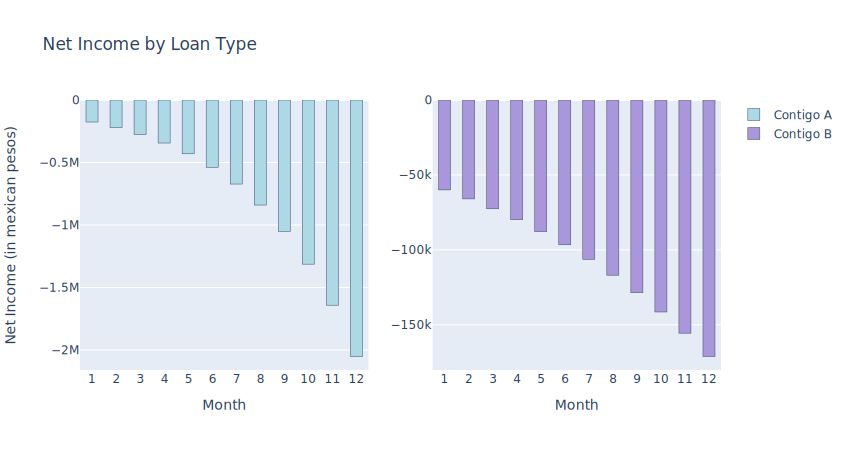

In [6]:
im.visualize_results(contigo_a_features,contigo_b_features)

In [7]:
im.compute_results(contigo_a_features,contigo_b_features)

,month,loan_type,accounts,delinquency_accounts,interest_revenue,delinquency_loss,operative_costs,net_income
0,1,Contigo A,5000,675,648750.00,675000.0,150000,-176250.00
1,2,Contigo A,6250,843,810937.50,843750.0,187500,-220312.50
2,3,Contigo A,7812,1054,1013607.00,1054620.0,234360,-275373.00
3,4,Contigo A,9765,1318,1267008.75,1318275.0,292950,-344216.25
4,5,Contigo A,12207,1647,1583858.25,1647945.0,366210,-430296.75
5,6,Contigo A,15258,2059,1979725.50,2059830.0,457740,-537844.50
6,7,Contigo A,19073,2574,2474721.75,2574855.0,572190,-672323.25
7,8,Contigo A,23841,3218,3093369.75,3218535.0,715230,-840395.25
8,9,Contigo A,29802,4023,3866809.50,4023270.0,894060,-1050520.50
9,10,Contigo A,37252,5029,4833447.00,5029020.0,1117560,-1313133.00


#### Profitable Scenarios

The startup could reach profitability in the following scenarios:

- `Delinquency Rate <= 10.43%` for **Contigo A**, if everything else stays the same.

loan_type             Contigo A      Contigo B          Total
interest_revenue  36,414,638.71  39,346,560.00  75,761,198.72
delinquency_loss  28,268,741.90  34,214,400.00  62,483,141.90
operative_costs    8,130,990.00   6,415,200.00  14,546,190.00
net_income            14,906.81  -1,283,040.00  -1,268,133.19


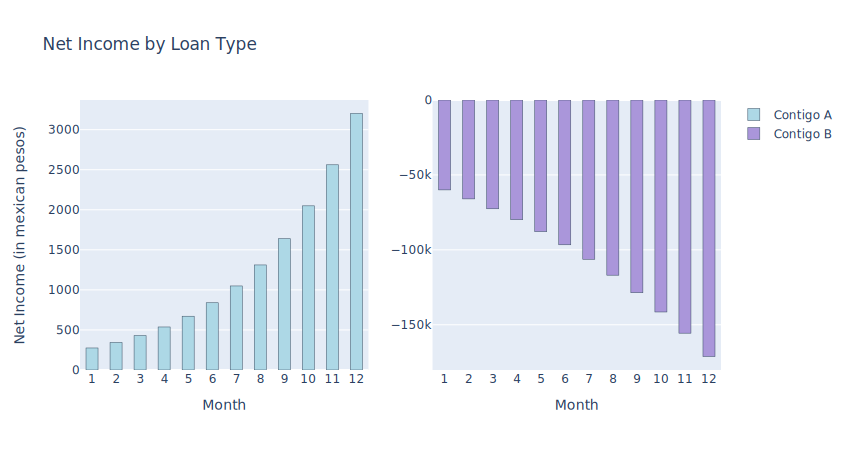

In [30]:
loan_a = contigo_a_features.copy()
loan_b = contigo_b_features.copy()

loan_a["delinquency_rate"] = 0.1043

print(im.overall_results(loan_a,loan_b))
im.visualize_results(loan_a,loan_b)

- `Delinquency Rate <= 7.7%` for **Contigo B**, if everything else stays the same.

loan_type             Contigo A      Contigo B          Total
interest_revenue  35,166,531.75  39,474,864.00  74,641,395.75
delinquency_loss  36,589,455.00  32,931,360.00  69,520,815.00
operative_costs    8,130,990.00   6,415,200.00  14,546,190.00
net_income        -9,553,913.25     128,304.00  -9,425,609.25


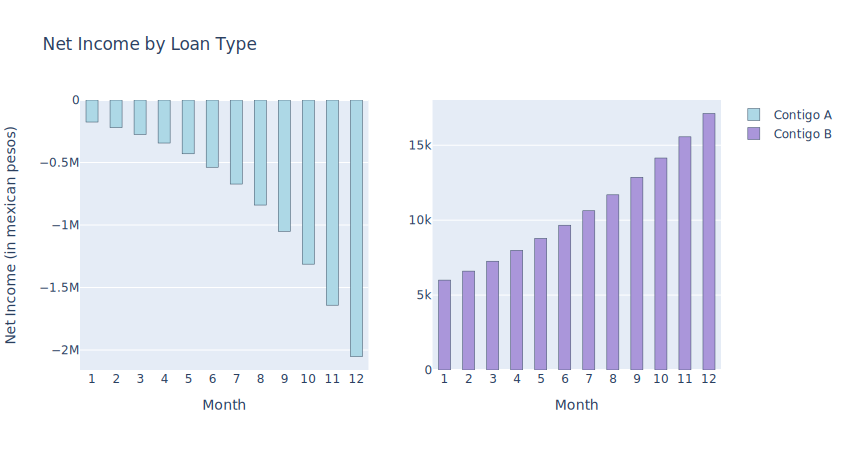

In [32]:
loan_a = contigo_a_features.copy()
loan_b = contigo_b_features.copy()

loan_b["delinquency_rate"] = 0.077

print(im.overall_results(loan_a,loan_b))
im.visualize_results(loan_a,loan_b)

- `Interest Rate >= 19.10%` for **Contigo A**, if everything else stays the same.

loan_type             Contigo A      Contigo B          Total
interest_revenue  44,778,717.09  39,346,560.00  84,125,277.09
delinquency_loss  36,589,455.00  34,214,400.00  70,803,855.00
operative_costs    8,130,990.00   6,415,200.00  14,546,190.00
net_income            58,272.09  -1,283,040.00  -1,224,767.91


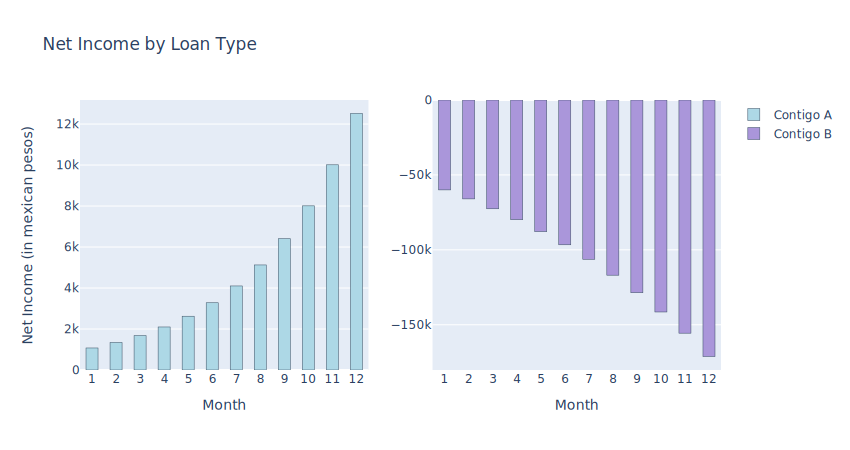

In [33]:
loan_a = contigo_a_features.copy()
loan_b = contigo_b_features.copy()

loan_a["interest_rate"] = 0.191

print(im.overall_results(loan_a,loan_b))
im.visualize_results(loan_a,loan_b)

- `Interest Rate >= 10.33%` for **Contigo B**, if everything else stays the same.

loan_type             Contigo A      Contigo B          Total
interest_revenue  35,166,531.75  40,644,996.48  75,811,528.23
delinquency_loss  36,589,455.00  34,214,400.00  70,803,855.00
operative_costs    8,130,990.00   6,415,200.00  14,546,190.00
net_income        -9,553,913.25      15,396.48  -9,538,516.77


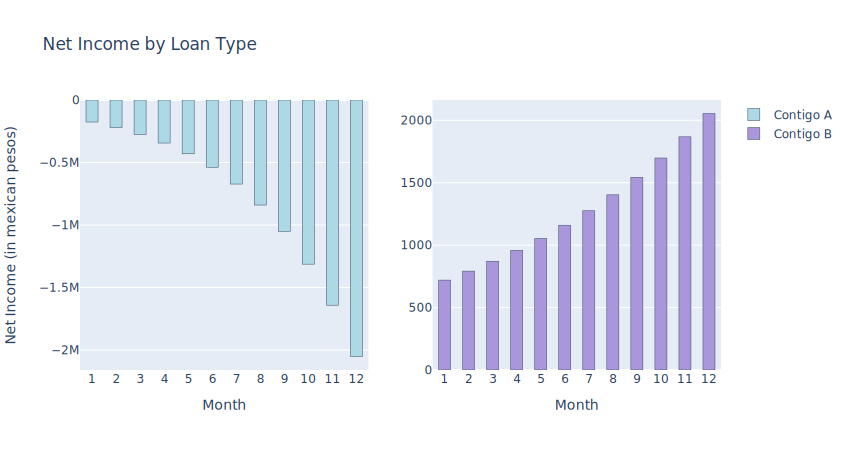

In [40]:
loan_a = contigo_a_features.copy()
loan_b = contigo_b_features.copy()

loan_b["interest_rate"] = 0.1033

print(im.overall_results(loan_a,loan_b))
im.visualize_results(loan_a,loan_b)

### Question 3

> What changes are required to sustain the business not only throughout the year but in the long run? Build a proposal of changes to main startup KPIs to achieve this goal. Discuss what difficulties the startup may find in applying your recommendation.

To sustain the business not only throughout the year but in the long run, the startup should focus on:
- Improving the credit risk assessment process to reduce the DQ rates.
- Diversify the revenue stream and reduce reliance on a single product.

Overall, the startup should aim to diversify their income to prevent dependence on a single product for their income.

KPI:
- Interest-to-Delinquency:

    * $\frac {InterestRate}{DelinquencyRate} \ge 1.24$ for Contigo A

    * $\frac {InterestRate}{DelinquencyRate} \ge 1.30$ for Contigo B